<a href="https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Video_Classification_w_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example is a successor to the [Video Classification with a CNN-RNN Architecture](https://keras.io/examples/vision/video_classification/) exammple. In this example, we will be using a Transformer-based ([Vaswani et al.](https://arxiv.org/abs/1706.03762))  model to classify videos. You can follow [this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) in case you need an introduction to Transformers with code. After reading this example, you will know how to develop a hybrid Transformer-based models for video classification that operate on CNN feature maps.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be installed using the following command:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 8.2MB/s 


## Data collection

As done in the [predecessor](https://keras.io/examples/vision/video_classification/) to this example, we will be using a subsampled version of the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php) which is a known benchmark dataset. In case you want to operate on a larger subsample or even the entire dataset, please refer to [this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb). 

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## Data preparation

We will mostly be following the same data preparation steps in this example except for the following changes:

* Reducing the image sizes to 128 instead of 224 to speed up computation. 
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network, we will be using a pre-trained [DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf) for feature extraction. 
* We will directly be padding the shorter videos to the `MAX_SEQ_LENGTH`. 

First, let's load up the [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). 

**Note**: In case you did not follow the data preparation steps in the previous example mentioned at the beginning, you are strongly advised to do that first before proceeding. 

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def crop_center_square(frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y : start_y+min_dim, start_x : start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(weights="imagenet", 
                                                       include_top=False, pooling="avg",
                                                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
# Label preprocessing with StringLookup.
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]),  mask_token=None
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()
    
    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),
                                dtype="float32")
    
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]
        
        # Initialize placeholder to store the features of the current video. 
        temp_frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                                dtype="float32")
        
        # Extract features from the frames of the current video. 
        for i, batch in enumerate(frames):  
            video_length = batch.shape[1]
            length = min(MAX_SEQ_LENGTH, video_length)  
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])  
                else:
                    temp_frame_featutes[i, j, :] = 0.0

        frame_features[idx, ] = temp_frame_featutes.squeeze()

    return frame_features, labels

Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes time to complete execution. This is why, to save time, we will use already prepared NumPy arrays.

In [ ]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [ ]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

We will be building on top of the code shared in [this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11) of [Deep Learning with Python (Second ed.)](https://www.manning.com/books/deep-learning-with-python) by François Chollet. First, self-attention layers that form the basic blocks of a Transformer are order-agnostic. Since, videos are ordered sequences of frames we would need our Transformer model to account for that. This is done via **positional encodings**. We will simply embed the positions of the frames present inside videos with [`layers.Embedding()`](https://keras.io/api/layers/core_layers/embedding). We will then add these positional embeddings to the precomputed CNN feature maps. 

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # Our inputs are of shape: `(batch_size, frames, num_features)
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

Now, we can create a subclassed layer for the Transformer. 

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

## Utility functions for training

In [ ]:
 def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())
    
    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(sequence_length, embed_dim, name="frame_position_emebedding")(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x, mask=None)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
    return model

In [ ]:
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, 
                                    save_best_only=True, verbose=1)
    
    model = get_compiled_model()
    history = model.fit(train_data, train_labels,
        validation_split=0.15,
        epochs=EPOCHS, 
        callbacks=[checkpoint])

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

## Model training and inference

In [ ]:
trained_model = run_experiment()

Epoch 1/5
16/16 [==============================] - 4s 27ms/step - loss: 1.0467 - accuracy: 0.7440 - val_loss: 0.1369 - val_accuracy: 0.9333

Epoch 00001: val_loss improved from inf to 0.13695, saving model to /tmp/video_classifier
Epoch 2/5
16/16 [==============================] - 0s 12ms/step - loss: 0.0743 - accuracy: 0.9861 - val_loss: 0.4864 - val_accuracy: 0.8111

Epoch 00002: val_loss did not improve from 0.13695
Epoch 3/5
16/16 [==============================] - 0s 10ms/step - loss: 0.0268 - accuracy: 0.9960 - val_loss: 1.7713 - val_accuracy: 0.6111

Epoch 00003: val_loss did not improve from 0.13695
Epoch 4/5
16/16 [==============================] - 0s 10ms/step - loss: 0.0214 - accuracy: 0.9940 - val_loss: 1.3068 - val_accuracy: 0.6556

Epoch 00004: val_loss did not improve from 0.13695
Epoch 5/5
16/16 [==============================] - 0s 10ms/step - loss: 0.0146 - accuracy: 0.9960 - val_loss: 1.3986 - val_accuracy: 0.6778

Epoch 00005: val_loss did not improve from 0.13695
7

**Note**: This model has ~4.23 Million parameters which is way more than the sequence model (99918 parameters) we used in the prequel of this example.  This kind of Transformer model is best off with more data and a larger pre-training schedule. 

In [ ]:
def prepare_single_video(frames):
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video. 
    for i, batch in enumerate(frames):  
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)  
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])  
            else:
                frame_featutes[i, j, :] = 0.0

    return frame_featutes


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: v_Punch_g07_c02.avi
  Punch: 100.00%
  TennisSwing:  0.00%
  PlayingCello:  0.00%
  CricketShot:  0.00%
  ShavingBeard:  0.00%



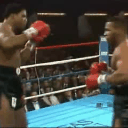

In [ ]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])